***
# Developing an RNN to Predict TD's Stock Price Given Historical Economic and Competitor Data
Author: Connor Lee
***
## Project Description
The primary goal of this project was to develop my first recurrent neural network (RNN) through developing an RNN that predicts the stock price of TD. The learning objectives from this project were the following:
* Learn how to develop an RNN that uses data from multiple sources
* Learn how to implement cross validation with a neural network

The idea behind using an RNN to predict stock price is to identify historical patterns of how the stock price relates to historical data from various sources that affect, or are related to the stock of interest's price, and use these patterns to predict the price of the stock in the future. The historical data that will be used to predict the stock price are listed below along with links to the datasets:

* [TD daily stock price and trading volume](https://ca.finance.yahoo.com/quote/TD.TO/history?period1=953769600&period2=1586476800&interval=1d&filter=history&frequency=1d)
* [Daily price of crude oil](https://ca.finance.yahoo.com/quote/CL%3DF/history?period1=953596800&period2=1586563200&interval=1d&filter=history&frequency=1d)
    * The Canadian economy, and therefore Canadian banks, depends heavily on the price of oil
* [Daily price of the S&P/TSX index](https://ca.finance.yahoo.com/quote/%5EGSPTSE/history?p=^GSPTSE&.tsrc=fin-srch)
    * As the second largest bank in Canada it does a good deal of lending to Canadian companies, so the performance of the Toronto Stock Exchange is likely to affect the banks stock price greatly
* Daily pricing of competitors (Canadian, US, and European)
    * Competing companies within the same industry are likely to experience similar price movement trends, as a result it is often possible to gain an understanding of how a companies price will move through observing the prices of its competitors
    * [The other Canadian big 5 banks](https://en.wikipedia.org/wiki/Banking_in_Canada#%22Big_Five%22_banks) 
        * [Royal Bank of Canada (RY.TO)](https://ca.finance.yahoo.com/quote/RY.TO/history?period1=953769600&period2=1586476800&interval=1d&filter=history&frequency=1d)
        * [The Bank of Nova Scotia (BNS.TO)](https://ca.finance.yahoo.com/quote/BNS.TO/history?period1=953769600&period2=1586476800&interval=1d&filter=history&frequency=1d)
        * [Bank of Montreal (BMO.TO)](https://ca.finance.yahoo.com/quote/BMO.TO/history?period1=953769600&period2=1586476800&interval=1d&filter=history&frequency=1d)
        * [Canadian Imperial Bank of Commerce (CM.TO)](https://ca.finance.yahoo.com/quote/CM.TO/history?period1=953769600&period2=1586476800&interval=1d&filter=history&frequency=1d)
    * [The top 3 US banks](https://disfold.com/top-us-banks/) 
        * [Bank of America Corporation (BAC)](https://ca.finance.yahoo.com/quote/BAC/history?period1=953769600&period2=1586476800&interval=1d&filter=history&frequency=1d)
        * [JPMorgan Chase & Co. (JPM)](https://ca.finance.yahoo.com/quote/JPM/history?period1=953769600&period2=1586476800&interval=1d&filter=history&frequency=1d)
        * [Wells Fargo & Company (WFC)](https://ca.finance.yahoo.com/quote/WFC/history?period1=953769600&period2=1586476800&interval=1d&filter=history&frequency=1d)
    * [The top 3 European banks](https://www.statista.com/statistics/273806/european-banks-with-the-most-valuable-brands/) 
        * [HSBC Holdings plc (HSBC)](https://ca.finance.yahoo.com/quote/HSBC/history?period1=953769600&period2=1586476800&interval=1d&filter=history&frequency=1d)
        * [Banco Santander, S.A. (SAN)](https://ca.finance.yahoo.com/quote/SAN/history?period1=953769600&period2=1586476800&interval=1d&filter=history&frequency=1d)
        * [BNP Paribas SA (BNP.PA)](https://ca.finance.yahoo.com/quote/BNP.PA/history?period1=953769600&period2=1586476800&interval=1d&filter=history&frequency=1d)
* The exchange rates between Canadian Dollar (CAD) and the [5 most traded curencies](https://en.wikipedia.org/wiki/Currency_pair#Base_currency) as of April 2019
    * Since TD is Canada's 2nd largest bank it’s performance likely depends greatly on the performance of the Canadian Dollar
    * [United States dollar (USD)](https://ca.investing.com/currencies/cad-usd-historical-data)
    * [Euro (EUR)](https://ca.investing.com/currencies/cad-eur-historical-data)
    * [Japanese yen (JPY)](https://ca.investing.com/currencies/cad-jpy-historical-data)
    * [Pound sterling (GBP)](https://ca.investing.com/currencies/cad-gbp-historical-data)
    * [Australian dollar (AUD)](https://ca.investing.com/currencies/cad-aud-historical-data)

The RNN for this project will use 15 years of data (from 2000-03-22 through 2015-04-09) and then will be tested on 5 years of data (from 2015-04-10 through 2020-04-09). The actual prices and predicted prices will then be plotted together in order to observe the RNN's ability to predict the stock price given the historical data.

## Data Preparation
The first step is to impor the required libaries, which is done in the following code chunk.

In [1]:
# Library Imports
# Library used in data importing process
import os

# Libraries for data manipulation
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# TensorFlow imports for creating the RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers

# TensorFlow and scikit-learn imports for cross validation of RNN
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Library for visualization
import matplotlib.pyplot as plt

Once all of the required libraries have been imported we can read in the training and testing data. The data is stored seperately as testing and training data due to limitaitons when downloading the data from some of the websites. Some of the sites required that the data be downloaded in 2 seperate batches because of this download size limitation it was more efficient to download the training and testing sets seperately. This incidentally made it easier to read in the training and testing sets seperately and then concatenate them together for when we get to predicting the test set. Another point of interest is that the required data was stored in eiter the 0th column (the currency exchange data), or the 3rd column (the remaining data), this is because the currency data was all collected from Investing.com, while the remaining data was collected from yahoo! finance.

The two for loops for reading in the data are identical other than the fact that they are reading in different datasets. They both contain the following:
* An if statement for setting the indexing range if the current file contains currency data
* An if statement for setting the indexing range if the current file does not contain currency data
* An if satement for if the current iteration is the first iteration
* An if statement for if the current file is the company we are predicting for

Once the required information from each file has been stored in the appropriate dataframe the two dataframes are concatenated together and any missing data is filled using the `fillna()` function and the forward fill method. The forward fill method was decided upon as it was found from some looking at the structure of the data that there were very few missing values, from experience working with financial data the price differences from one day to the next are typically relatively small, so the occasional day where there is no change in a small portion of the values is unlikely to have a noticable effect on the overall model. The fully combined dataset will not be used until we are testing the model fit, however it was completed at this stage since it was deamed simpler to perform all the data preparation at the same time.

In [2]:
# Storing company ticker to make it easy to change company being predicted for (ex. could change to RY and predict for RY instead of TD)
company = 'td'
# Path to the testing data
path = 'test_data/'
# Variable for handeling the first iteration in the for loop
isFirst = True
# For loop to read and store the appropriate columns from the different data files in a datafame
for file in sorted(os.listdir(path)):
    if 'cad' in file:
    # Case for the exchange rate files
        idx0 = 0
        idx1 = 1
    else:
    # Case for the rest of the files
        idx0 = 3
        idx1 = 4
    if isFirst == True and file != company+'_test.csv':
    # Case for the first iteration
        add_test = pd.read_csv(path+file, index_col=0).iloc[:, idx0:idx1]
        isFirst = False
    if file != company+'_test.csv':
    # Case for if the current file corresponds to the company that we are predicting for (skipped here b/c accounted for later)
        add_test = pd.concat([add_test, pd.read_csv(path+file, index_col=0).iloc[:, idx0:idx1]], join="inner", axis=1)

# Pat to the training data
path = 'training_data/'
# Variable for handeling the first iteration in the for loop
isFirst = True
# For loop to read and store the appropriate columns from the different data files in a datafame
for file in sorted(os.listdir(path)):
    if 'cad' in file:
    # Case for the exchange rate files
        idx0 = 0
        idx1 = 1
    else:
    # Case for the rest of the files
        idx0 = 3
        idx1 = 4
    if isFirst == True and file != company+'_train.csv':
    # Case for the first iteration
        add_train = pd.read_csv(path+file, index_col=0).iloc[:, idx0:idx1]
        isFirst = False
    if file != company+'_train.csv':
    # Case for if the current file corresponds to the company that we are predicting for (skipped here b/c accounted for later)
        add_train = pd.concat([add_train, pd.read_csv(path+file, index_col=0).iloc[:, idx0:idx1]], join="inner", axis=1)

# Concatenating all data into one dataframe for use during the fitting process
add_all = pd.concat([add_train, add_test], axis=0)
add_all.fillna(method='ffill', inplace=True)

The next step is to import the training data for the company that we are trying to predict for, and concatenating the training data previously collected to it, this ensures that the pricing and trading volume for the company we are predicting for are always in the first two columns of the dataframe. We then convert the training_set dataframe to a numpy array as the required input for the function we will use for feature scaling, and for the LSTM layers in Keras are numpy arrays.

In [3]:
# Importing the training set
dataset_train = pd.read_csv('training_data/'+company+'_train.csv', index_col=0)
training_set = pd.concat([dataset_train.iloc[:, np.r_[3:4,5:6]], add_train], join='inner', axis=1)
training_set.fillna(method='ffill', inplace=True)
training_set = training_set.values

The next step is to scale the dataset so that the magnitudes of the different values don't result in any one column dominating the predictions (for example the price of the TSX index is much larger than any of the exchange rates). We will use the `MinMaxScaler()` function from scikit-learn to scale the data so that it ranges from 0 to 1.

In [4]:
# Feature Scaling
## Creating scalar object
sc = MinMaxScaler(feature_range=(0,1))
## Scaling training set
training_set_scaled = sc.fit_transform(training_set)

Now that the data has been scaled we can set the LSTM memory range (or timestep) by storing vectors of data for the last 80 days (found to provide the best performance through testing various different values) and storing them for each day to be trained on. This is done so that the LSTM layers can go through the array row by row and easily access the last 80 days of data. The data is broken into x_train (predictor variables) and y_train (response) so that the predictor variables and response values can be easily passed into the RNN. Finally the x_train array is reshaped into a shape that the RNN can accept.

In [5]:
# Creating a data structure with timestep timesteps and 1 output
timestep = 80 # The number of days in the past to include in the prediction (found through testing various different values)
x_train = []
y_train = []
# For loop to append the last 80 days worth of data to each row of the training numpy arrays
for i in range(timestep, len(training_set_scaled)):
    x_train.append(training_set_scaled[i-timestep:i, :])
    y_train.append(training_set_scaled[i,0])

# Converting the lists to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshaping the x_train data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2])) 

## Cross Validating RNN parameters
Now that the data has been prepared in a manner that it can be passed into an RNN we can build an RNN using a Sequential model with a combination of LSTM, Dropout, and Dense layers. The number of LSTM layers, Dense Layers, units in the LSTM layers, and dropout rate were all found from testing various models. The mean squared error (MSE) was selected as the loss function since it is the generally accepted standard loss function for regression problems like this, and there is no reason to believe that the data has any underlying characteristics that indicate that the MSE shouldn't be used.

The remaining parameters including batch size, number of epochs, and the optimizer selected for the final configuraiton were identified using cross validation by implementing the `GridSearchCV()` function from scikit-learn. Cross validation is an extremely usefull way to test your model as it does a better job of estimating long run MSE than just using a training and test set, however it can be computationally intensive for large datasets as it consists of fitting the model multiple times. Five fold cross validation was chosen for this project over the typical ten fold cross validation in the interest of time since ten fold cross validation takes twice as long as five fold cross validation. The cross validation setup used for this project is shown below, however it is recommended that the following code chunk not be run as is since `GridSearchCV()` will run five iterations of each possible combination of parameters shown below which will take an extremely long time to run. Please note that cell type of the following two cells have been changed to 'Raw' so that they are not accidentally run, to run the code in them they need to be changed to 'Code'.

The following code chunk will display the best parameter configuration and the best MSE found by the `GridSearchCV()` function in the above code chunk.

The output of the best parameters isn't shown above due to the amount of time it takes to run the cross validation, however the best parameter configuraiton found is shown below:
* Batch Size: 32
* Epochs: 45
* Optimizer: Adam

# Building and Fitting the RNN with Optimal Parameters
Now that the optimal parameters have been identified we can use these parameters to build and fit an RNN that has been optimized for this data that we can then use to predict the TD stock price.

In [6]:
# Initializing the RNN
regressor = Sequential()

# Adding LSTM and Dropout regularization layers
regressor.add(LSTM(units=75, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
regressor.add(Dropout(rate=0.2))
regressor.add(LSTM(units=75, return_sequences=True))
regressor.add(Dropout(rate=0.2))
regressor.add(LSTM(units=75))
regressor.add(Dropout(rate=0.2))

# Adding the output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

In [7]:
# Fitting the RNN to the training set
regressor.fit(x_train, y_train, epochs=45, batch_size=32)

Train on 3633 samples
Epoch 1/45
3633/3633 [==============================] - 12s 3ms/sample - loss: 0.0089
Epoch 2/45
3633/3633 [==============================] - 9s 2ms/sample - loss: 0.0026
Epoch 3/45
3633/3633 [==============================] - 9s 2ms/sample - loss: 0.0021
Epoch 4/45
3633/3633 [==============================] - 9s 2ms/sample - loss: 0.0022
Epoch 5/45
3633/3633 [==============================] - 9s 2ms/sample - loss: 0.0018
Epoch 6/45
3633/3633 [==============================] - 9s 2ms/sample - loss: 0.0019
Epoch 7/45
3633/3633 [==============================] - 9s 2ms/sample - loss: 0.0018
Epoch 8/45
3633/3633 [==============================] - 9s 2ms/sample - loss: 0.0017
Epoch 9/45
3633/3633 [==============================] - 9s 2ms/sample - loss: 0.0015
Epoch 10/45
3633/3633 [==============================] - 9s 2ms/sample - loss: 0.0015
Epoch 11/45
3633/3633 [==============================] - 9s 2ms/sample - loss: 0.0015
Epoch 12/45
3633/3633 [=================

## Predicting on New Data and Comparing to What Actually Happened
Now that we have used cross validation to identify the best configuration of our model, and we have created and fit our model to the data with our optimized configuraiton, we can pass in the five years of testing data to predict the stock prices for each day in that five year testing period. First we will extract the stock prices and training volumes over the testing period, then we will combine the testing and training stock prices and trading volumes with the previously generated dataset of the other predictor variables. From this combined dataset we can extract the required data for testing, which consists of the 80 days before the testing period, and the entire testing period. Since each prediciton requires the previous 80 days we need the data from the last 80 days of the training period in order to make predicitons on the first 80 days of the testing period.

In [8]:
# Getting the actual stock prices for the testing period
dataset_test = pd.read_csv('test_data/'+company+'_test.csv', index_col=0)
act_stock_price = dataset_test.iloc[:, 3:4].values
# Adding the actual stock prices and trading volumes for the training and test to the previously generated dataset of other predictor variables
dataset_total = pd.concat([pd.concat([dataset_train.iloc[:, np.r_[3:4,5:6]], dataset_test.iloc[:, np.r_[3:4,5:6]]], axis=0), add_all], join='inner', axis=1)
# Get the data from 80 days before the first day of the testing period thorugh the end of the testing period (need 80 days before the testing period so we can predict the first 80 days of the testing period)
inputs = dataset_total[len(dataset_total)-len(dataset_test)-timestep:].values
# Transformingthe inputs to get the same scaling as the fit data
inputs = sc.transform(inputs)

Next we will perform the same data preparation we completed on the training set in order to format the data such that it can be predicted from.

In [9]:
# Creating the appropriate datastructure for predicting
x_test = []

for i in range(timestep, len(inputs)):
    x_test.append(inputs[i-timestep:i, :])

# Converting data to numpy array
x_test = np.array(x_test)

# Reshaping the data to the appropriate shape
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

Finally we can perform predictions on our appropriately formatted testing data and transform it back to the original scale in order to get the predicted stock prices. The additional step of appending an array of zeros to the predicted price before transforming the data back to the original scale is required since the original transformation was done on a larger array we need to provide the same input size in order to be able to complete the back transformation.

In [10]:
# Making the predictions
predicted_stock_price = regressor.predict(x_test)
# Adding an array of zeros to provide the correct dimensions for transforming the data back to the original scale
predicted_stock_price = np.append(predicted_stock_price, np.zeros(shape=(len(predicted_stock_price), dataset_total.shape[1]-1)), axis=1)
# Revert back to the original scale
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

Now that we have predicted pricing for each day we can plot our predicted stock prices, and the actual stock prices over testing period to see how well our model performs.

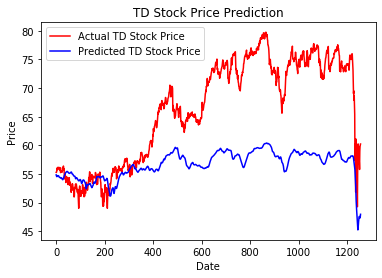

In [11]:
# Visualizing the results
plt.plot(act_stock_price, color='red', label='Actual TD Stock Price')
plt.plot(predicted_stock_price[:,0], color='blue', label='Predicted TD Stock Price')
plt.title('TD Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

From the above plots we can see that the RNN does a reasonable job a predicting the stock price trends and approximate price for the first year, however unfortunately after the first year it fails to predict the approximate price. Interestingly after the first year it continues to predict the general movement trends but fails to predict the magnitude of the movements. Since we can see that this model does a relatively good job of predicting movement trends, but fails to predict the magnitude of the price movements this model could be of some use in predicting the direction of price movement on a day to day basis. Possible alternatives to this model that may perform better are the following:
* Modify it to be a binary classificaiton problem that predicts if the price will go up or down
* Modify it to refit the model to all data after every year in order to include more recent trends in the model fit
* Modify it to predict the price a preset number of days ahead (ex. predict the price two weeks from now)